In [1]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose # descomposicion de los datos
from statsmodels.tsa.stattools import adfuller # Test de Dickey-Fuller (estacionaridad)
from statsmodels.tsa.statespace.sarimax import SARIMAX # modelo para el forecating
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Función de autocorrelación/ autocorrelación parcial (parámetros modelo ARIMA)
from sklearn.metrics import r2_score
from pmdarima.arima import auto_arima

Datos de los gases de efecto invernadero Globales (datos de NOAA) 

- <b>Ref</b>: Dr. Pieter Tans, NOAA/GML (gml.noaa.gov/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (scrippsco2.ucsd.edu/).

https://gml.noaa.gov/ccgg/trends/data.html

In [2]:
def read_data_annual(file,gas):
    file_path=file
    df=pd.read_csv(file_path)
    df=df.set_index("year")
    df.index = pd.to_datetime(df.index,format='%Y')
    df.rename(columns={"mean": gas},inplace=True)
    return df

def read_data_monthly(file,gas):
    file_path=file
    df=pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
    df=df.set_index("date")
    df.drop("year",axis=1,inplace=True)
    df.drop("month",axis=1,inplace=True)
    df.drop("decimal",axis=1,inplace=True)
    # Comparación datos originales y predichos por el modelo para el CO2
    if gas == "CO2":
        df.rename(columns={"average": gas},inplace=True) 
        df.drop("trend",axis=1,inplace=True)
    else:
        df.rename(columns={"average": gas,"average_unc":"unc"},inplace=True) 
        df.drop("trend",axis=1,inplace=True)
        df.drop("trend_unc",axis=1,inplace=True)
    return df

In [3]:
# Leemos los ficheros y modificamos las tablas para crearlas como nosotros queremos
data_CO2_mensual=read_data_monthly("tablas_ini/NOAAdata_CO2_monthly.csv","CO2")
data_CO2_anual=read_data_annual("tablas_ini/NOAAdata_CO2_annual.csv","CO2")

data_N2O_mensual=read_data_monthly("tablas_ini/NOAAdata_N2O_monthly.csv","N2O")
data_N2O_anual=read_data_annual("tablas_ini/NOAAdata_N2O_annual.csv","N2O")

data_CH4_mensual=read_data_monthly("tablas_ini/NOAAdata_CH4_monthly.csv","CH4")
data_CH4_anual=read_data_annual("tablas_ini/NOAAdata_CH4_annual.csv","CH4")

data_SF6_mensual=read_data_monthly("tablas_ini/NOAAdata_SF6_monthly.csv","SF6")
data_SF6_anual=read_data_annual("tablas_ini/NOAAdata_SF6_annual.csv","SF6")

In [4]:
# Unimos todas las tablas
data_anual = pd.concat([data_CO2_anual, data_N2O_anual,data_CH4_anual,data_SF6_anual], axis=1)
data_mensual = pd.concat([data_CO2_mensual, data_N2O_mensual,data_CH4_mensual,data_SF6_mensual], axis=1)


In [5]:
# Extraemos de la fecha por un lado los meses y por otro los años, guardamos la información de dos nuevas columnas
data_month=data_mensual.reset_index()
data_anual_temp=data_anual.reset_index()

data_month['month'] = data_month['date'].dt.month
data_month['year'] = data_month['date'].dt.year

data_anual_temp['año'] = data_anual_temp['year'].dt.year

data_month=data_month.set_index("date")
# data_temp=data_anual.set_index("year")

#### Estadística de los datos

In [6]:
# estadistica de los datos
data_anual.describe()

,CO2,unc,N2O,unc,CH4,unc,SF6,unc
count,41.000000,4.100000e+01,20.000000,20.000000,37.000000,37.000000,23.000000,23.000000
mean,371.525854,1.000000e-01,324.013500,0.126000,1769.115676,0.599459,6.923478,0.003522
std,21.880138,1.405019e-17,5.273355,0.013139,57.565462,0.089503,1.896033,0.001039
min,338.910000,1.000000e-01,316.360000,0.100000,1644.680000,0.420000,4.210000,0.002000
25%,354.050000,1.000000e-01,319.592500,0.120000,1736.490000,0.540000,5.340000,0.003000
50%,368.960000,1.000000e-01,323.700000,0.125000,1773.360000,0.580000,6.750000,0.004000
75%,388.760000,1.000000e-01,328.365000,0.140000,1803.110000,0.660000,8.415000,0.004000
max,412.440000,1.000000e-01,333.030000,0.150000,1879.100000,0.810000,10.270000,0.006000


In [7]:
# estadistica de los datos
data_mensual.describe()

,CO2,N2O,unc,CH4,unc,SF6,unc
count,502.000000,249.000000,249.000000,459.000000,459.000000,291.000000,291.000000
mean,372.381733,324.388755,-0.196386,1769.844880,0.856209,6.978522,-0.266440
std,22.281381,5.407204,1.772035,60.633767,1.456974,1.964954,1.622506
min,337.050000,316.100000,-9.900000,1625.900000,-9.900000,4.000000,-9.900000
25%,354.000000,319.700000,0.100000,1736.650000,0.900000,5.245000,0.005000
50%,369.680000,324.100000,0.100000,1774.600000,1.000000,6.770000,0.006000
75%,390.265000,328.900000,0.100000,1807.150000,1.100000,8.615000,0.006000
max,416.080000,334.400000,0.200000,1900.500000,2.900000,10.690000,0.013000


array([[<AxesSubplot:title={'center':'CO2'}>,
        <AxesSubplot:title={'center':'N2O'}>],
       [<AxesSubplot:title={'center':'CH4'}>,
        <AxesSubplot:title={'center':'SF6'}>]], dtype=object)

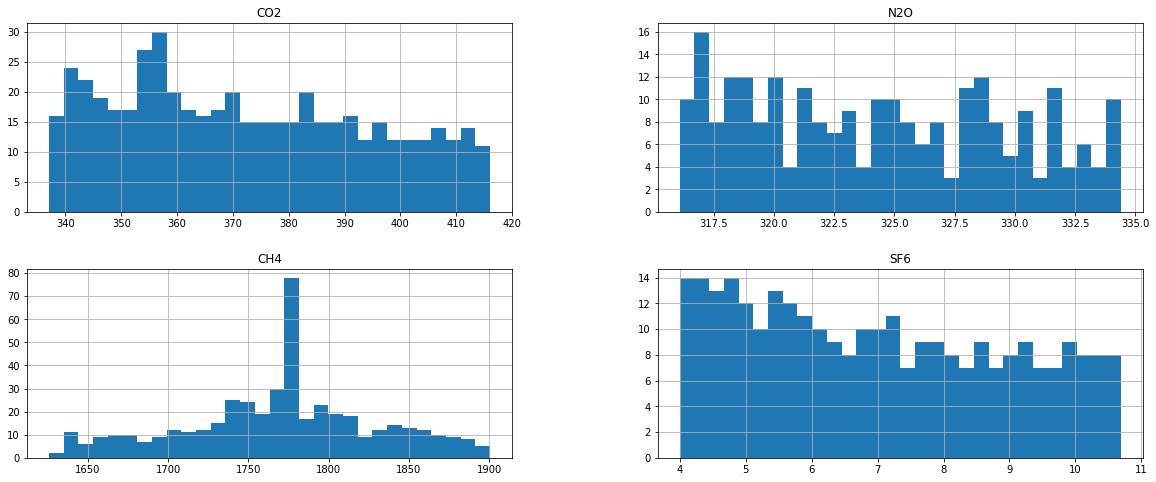

In [8]:
# Histograma de los datos
data_mensual.hist(column=["CO2","N2O","CH4","SF6"],bins=30, figsize=(20, 8))

#### Representación de los datos

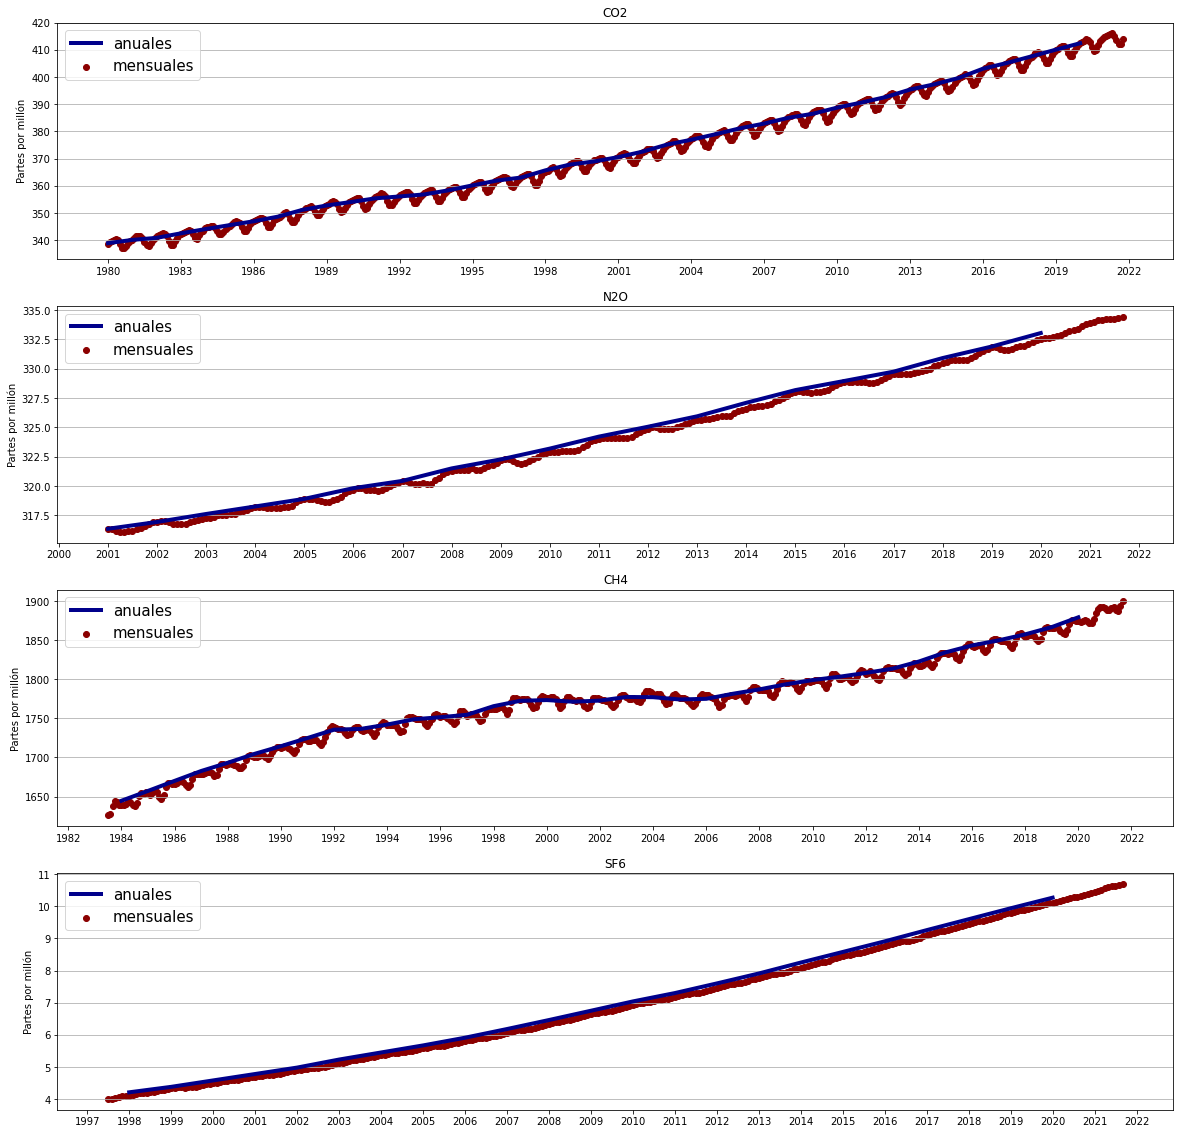

In [9]:
# Representación de los datos mensuales y anuales
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(20,20),sharex=False)

b=["CO2","N2O","CH4","SF6"]
year=[3,1,2,1]

for i in range(len(b)):

    ax[i].scatter(data_mensual.index,data_mensual[b[i]],c="darkred",label="mensuales")
    ax[i].plot(data_anual.index,data_anual[b[i]],c="darkblue",lw=4,label="anuales")

    ax[i].set_title(b[i])
    ax[i].yaxis.grid()
    ax[i].set_ylabel('Partes por millón')
    ax[i].legend(fontsize=15, loc="upper left")

    ax[i].xaxis.set_major_locator(mdates.YearLocator(year[i]))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax[i].tick_params(axis='x', rotation=0)

#### Distribución de los datos

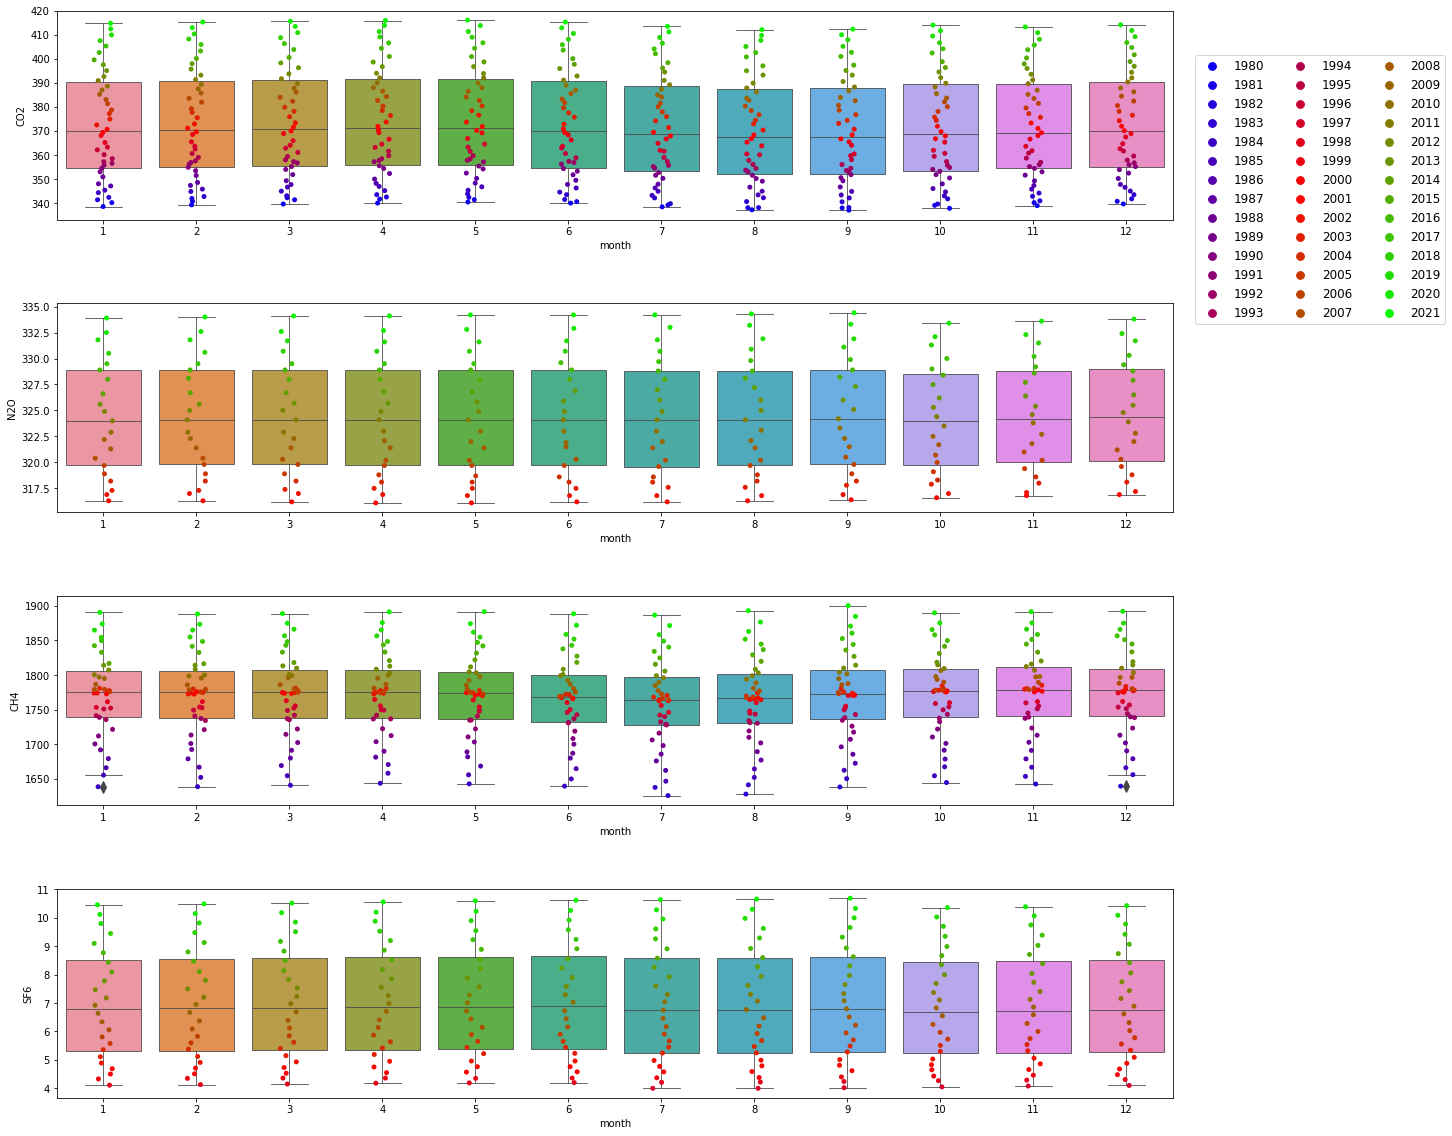

In [10]:
# Boxplot de los datos de cada gas para cada mes + scatterplot de los datos mensuales
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(20,20),sharex=False)
fig.subplots_adjust(hspace=0.4, wspace=0.2)

a=["CO2","N2O","CH4","SF6"]

for i in range(len(a)):
    sns.stripplot(x=data_month["month"], y=data_month[a[i]],hue=data_month["year"],ax=ax[i],size=5,jitter=True,
                 palette='brg')
    sns.boxplot(x=data_month["month"], y=data_month[a[i]],ax=ax[i],fliersize=8,linewidth=0.8)

    handles, labels = ax[0].get_legend_handles_labels()
    ax[i].legend('',frameon=False)
    ax[0].legend(handles, labels,loc=(1.02,-0.5),fontsize=12,ncol=3)

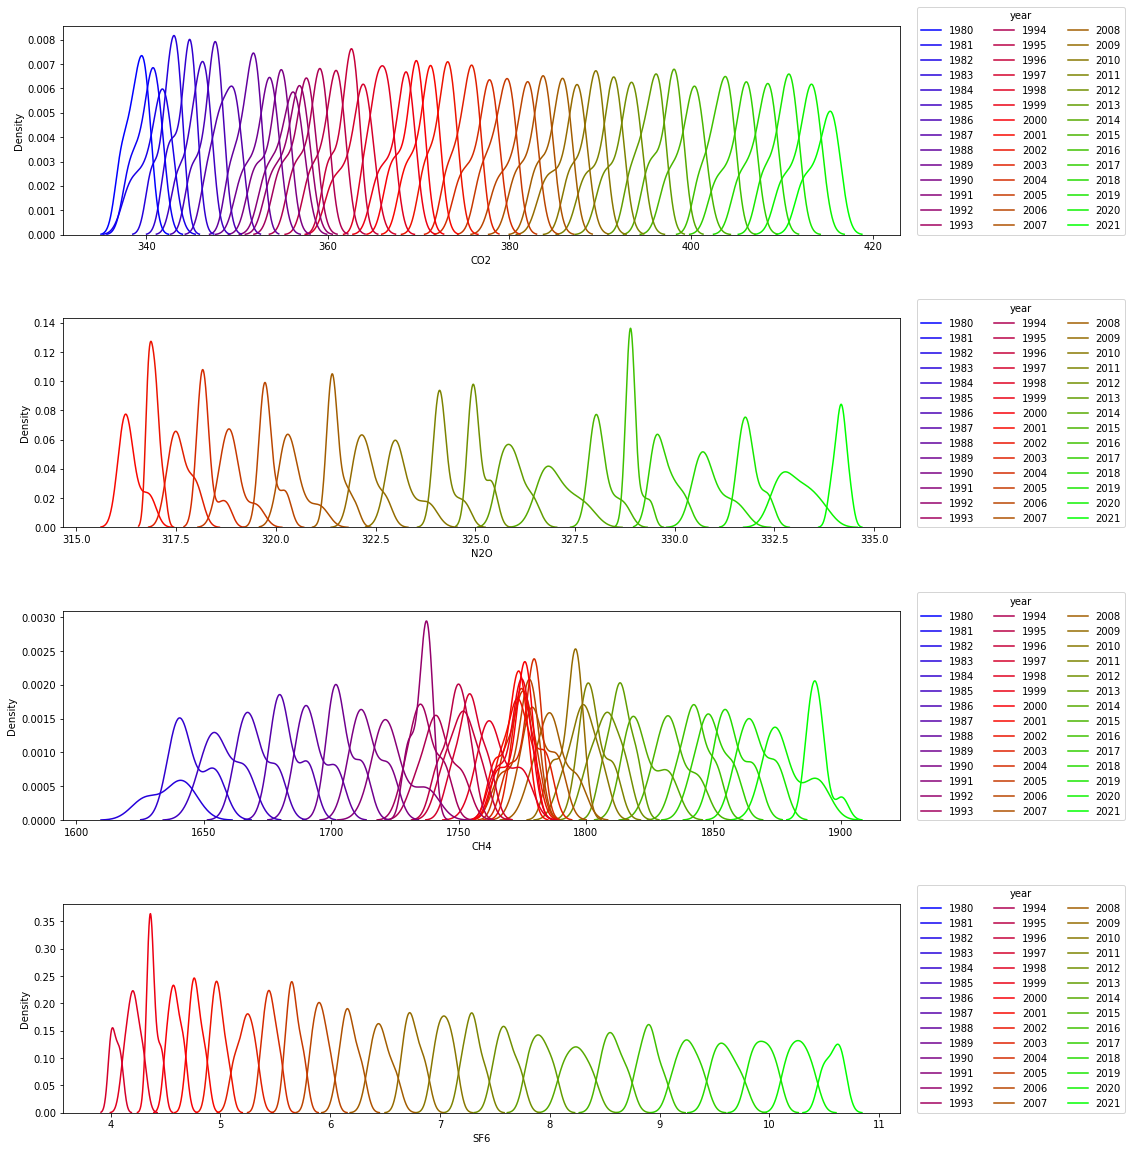

In [11]:
# Representación de la distrubución (KDE) por años  de los gases medidos cada mes
fig = plt.figure(figsize=(15,20))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

a=["CO2","N2O","CH4","SF6"]

for i in range(len(a)):
    ax = fig.add_subplot(4, 1, i+1)
    plot=sns.kdeplot(x=data_month[a[i]].dropna(axis=0),hue=data_month["year"].dropna(axis=0),
                     palette='brg',ax=ax,warn_singular=False)
    sns.move_legend(ax, ncol=3, loc=(1.02,0))


#### Estudio de la estacionaridad

In [12]:
# Función en la que estimamos los diferentes parámetros y plots para hacer el estudio de la estacionaridad
def test_stacionary(df,ventana,gas):
    
    # Cálculo de las propiedades la média móvil y la desviación std. móvil
    df_mov_avg=df.rolling(ventana).mean()
    df_mov_std=df.rolling(ventana).std()
        
    # Representamos los datos junto con la média móvil y la desviación std. móvil
    fig, ax1 = plt.subplots(1,1,figsize=(20,5))
    ax2=ax1.twinx()

    plot1=ax1.plot(df.index,df,c='blue',label="datos mensuales",lw=3)
    plot2=ax1.plot(df_mov_avg.index,df_mov_avg,"-",label="promedio",c="black",lw=3)
    plot3=ax2.plot(df_mov_std.index,df_mov_std,"-",label="desviación std.",c="red",lw=3)
    ax1.set_title(str(gas)+" --  datos originales")
    ax1.set_ylabel('Partes por millon')
    ax2.set_ylabel('Partes por millon')
    ax1.yaxis.grid()
    ax2.set_ylim((0,20))

    lns1 = plot1
    labs1 = [l.get_label() for l in lns1]
    lns2 = plot2+plot3
    labs2 = [l.get_label() for l in lns2]

    ax1.legend(lns1,labs1,loc=(1.05,0.8),fontsize=14, fancybox=True, shadow=True)
    ax2.legend(lns2,labs2,loc=(1.05,0.5),fontsize=14, fancybox=True, shadow=True)
    ax2.get_legend().set_title("Estadisticas móviles \n con ventana de "+str(ventana)+": \n",prop={'size':16})
    plt.show()
    
    # Test de Dickey-Fuller:
    dftest = adfuller(df.dropna(axis=0), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print("\n-- Test de Dickey-Fuller:")
    print(dfoutput)  
        


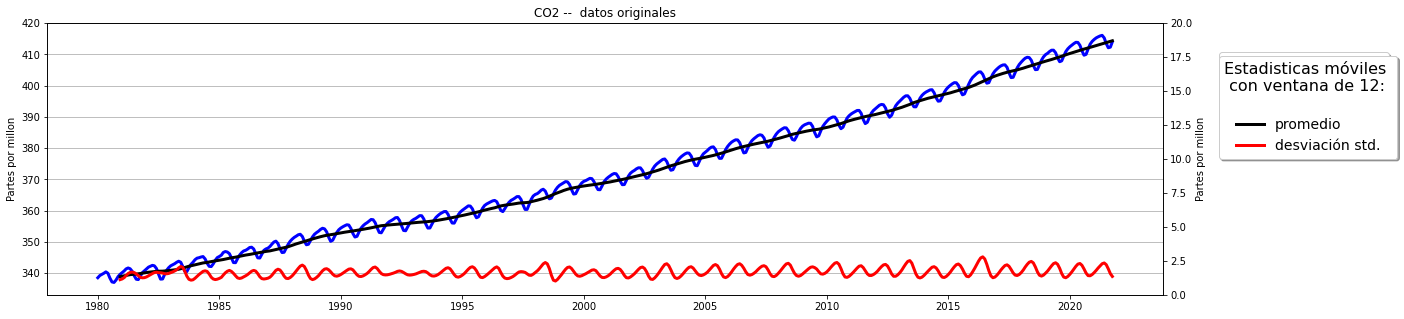


-- Test de Dickey-Fuller:
Test Statistic                   3.263791
p-value                          1.000000
#Lags Used                      18.000000
Number of Observations Used    483.000000
Critical Value (1%)             -3.443962
Critical Value (5%)             -2.867543
Critical Value (10%)            -2.569967
dtype: float64


In [13]:
# Estudio de la estacionaridad para los datos de CO2:
# fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20,5),sharex=False)
test_stacionary(data_mensual["CO2"],12,"CO2")

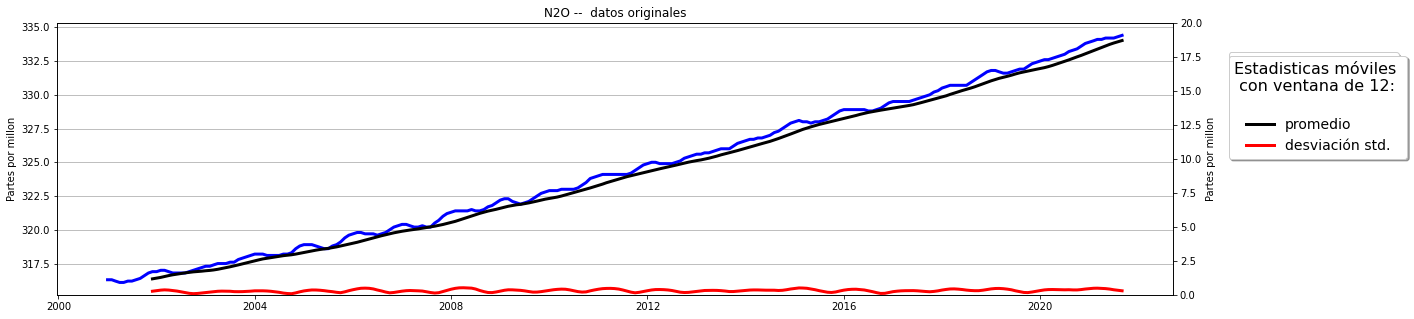


-- Test de Dickey-Fuller:
Test Statistic                   2.421504
p-value                          0.999020
#Lags Used                      13.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


In [14]:
# Estudio de la estacionaridad para los datos de N2O:
test_stacionary(data_mensual["N2O"],12,"N2O")

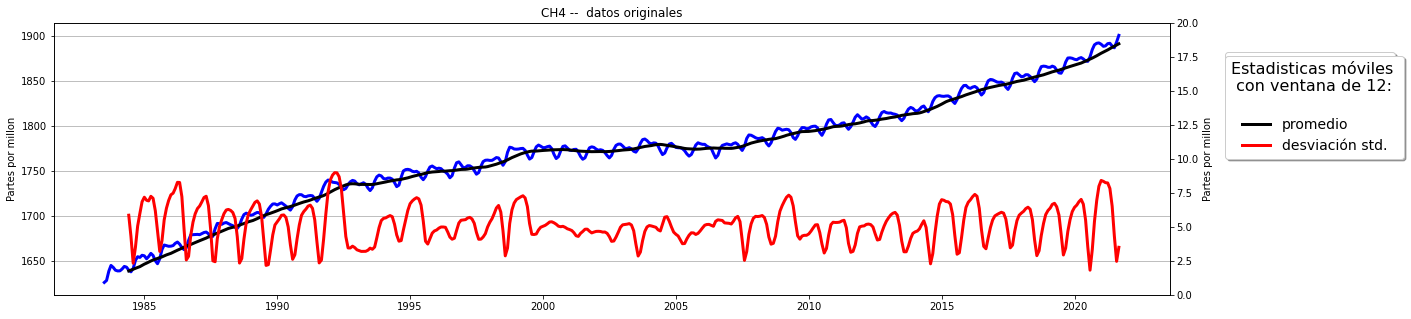


-- Test de Dickey-Fuller:
Test Statistic                   0.011126
p-value                          0.959443
#Lags Used                      16.000000
Number of Observations Used    442.000000
Critical Value (1%)             -3.445232
Critical Value (5%)             -2.868101
Critical Value (10%)            -2.570265
dtype: float64


In [15]:
# Estudio de la estacionaridad para los datos de CH4:
test_stacionary(data_mensual["CH4"],12,"CH4")

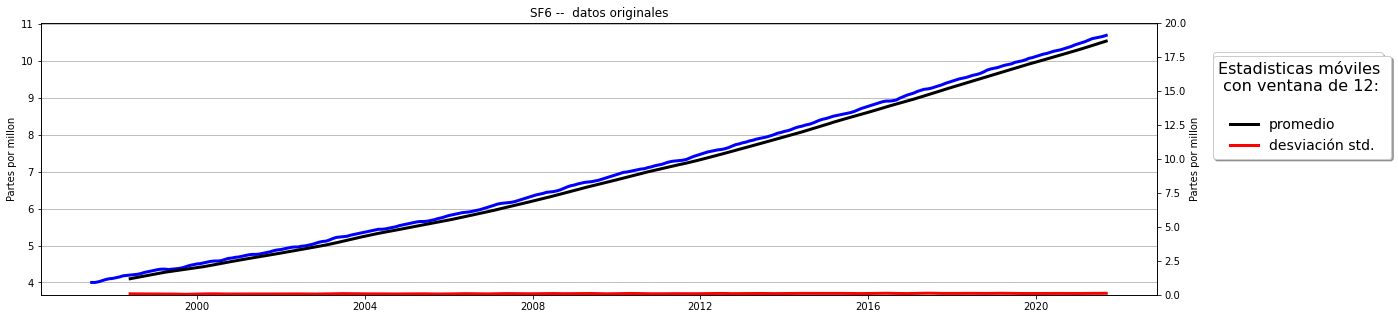


-- Test de Dickey-Fuller:
Test Statistic                   3.389398
p-value                          1.000000
#Lags Used                      15.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


In [16]:
# Estudio de la estacionaridad para los datos de SF6:
test_stacionary(data_mensual["SF6"],12,"SF6")

** Ninguna de las series temporales son estacionarias. Se aprecia una clara tendencia ascendente dependiente del tiempo

#### Forecasting usando SARIMA(p,d,q)x(P,D,Q,M)

In [17]:
# Separamos los datos entre los de train y los de test.

def sep_data(data,gas):
    data_temp=data_mensual[gas].dropna(axis=0)
    train_data=data_temp[:int(len(data_temp)/4)*3]
    test_data=data_temp[int(len(data_temp)/4)*3:]
    
    return train_data,test_data

In [18]:
# Determinación de los parámetros del modelo ARIMA

def val_p_q(data):
    plt.figure(figsize=(20,5))

    ax1=plt.subplot(121)  # Función de autocorrelación
    plot_acf(data.dropna(axis=0), lags=15,ax=ax1,title="Función de autocorrelación")
    ax1.set_ylim((-1.2,1.2))
    
    ax2=plt.subplot(122) # Función de autocorrelación parcial
    plot_pacf(data.dropna(axis=0), lags=15,ax=ax2,title="Función de autocorrelación parcial")
    ax2.set_ylim((-1.2,1.2))
    plt.show()


In [19]:
# Función para aplicar los modelos de Forecasting

def forecasting(data,p,d,q,P,D,Q,M):
    print("\n -- modelo SARIMA("+str(p)+", "+str(d)+", "+str(q)+")x("+str(P)+", "+str(D)+", "+str(Q)+str(M)+")")
    model_SARIMA=SARIMAX(data.dropna(axis=0),order=(p,d,q),seasonal_order=(P, D, Q, M))
    results_SARIMA=model_SARIMA.fit()
    print(results_SARIMA.summary())
    
    residuals = pd.DataFrame(results_SARIMA.resid)
    fig, ax = plt.subplots(1,1,figsize=(10,4))
    residuals.plot(kind='kde', title='Density', ax=ax)
    ax.set_xlim((-200,200))
    plt.show()
    print("-- Resumen de los residuos:")
    print(residuals.describe())


    return results_SARIMA

In [20]:
def predicion_datos(data,model_fit,gas):

    fc = model_fit.predict(start=len(data["data train"].dropna(axis=0)), end=(len(data["all data"])-1), dynamic=False) 
    data["predictions"] = pd.Series(fc, index=data["data test"].index)

    plt.figure(figsize=(20,8))
    plt.plot(data["data train"], label='training data')
    plt.plot(data["data test"], label='test data')
    plt.plot(data["predictions"] , label='forecast data')
    plt.title(gas)
    plt.legend(loc='upper left', fontsize=12)
    plt.show()
    
    r2=r2_score(data_CO2["data test"].dropna(axis=0),data_CO2["predictions"].dropna(axis=0))
    print("r2: "+str(r2))
    

In [21]:
# data_CO2=pd.DataFrame(columns=["all data","data train","data test","diff","seasonal","diff seasonal"])
data_CO2=pd.DataFrame(columns=["all data","data train","data test"])
data_CO2["all data"]=data_mensual["CO2"]
# data_CO2


 --- Datos observados:

 ** A) Primera diferencia


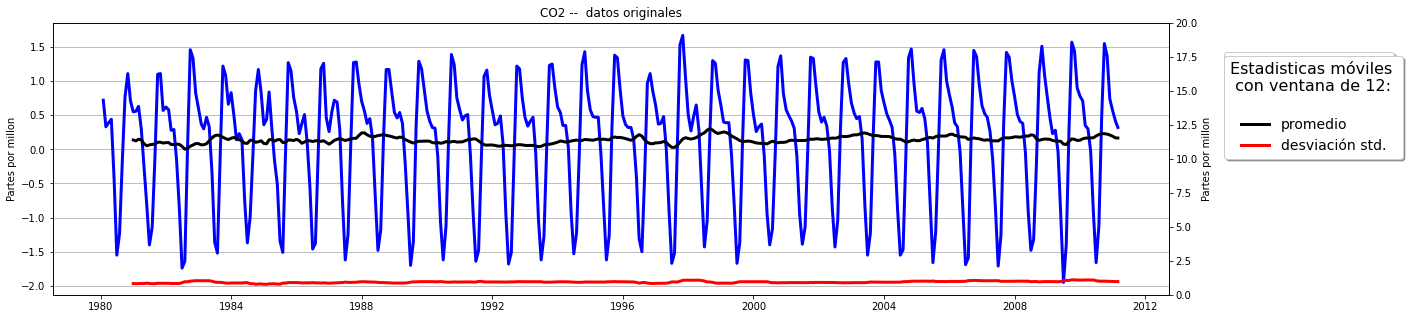


-- Test de Dickey-Fuller:
Test Statistic                  -3.999008
p-value                          0.001416
#Lags Used                      17.000000
Number of Observations Used    356.000000
Critical Value (1%)             -3.448853
Critical Value (5%)             -2.869693
Critical Value (10%)            -2.571114
dtype: float64

 ** B) Determinación de p y q:


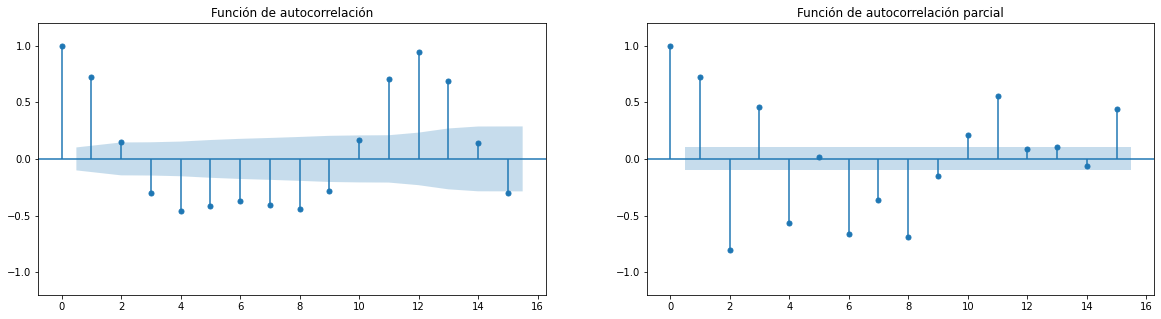


 --- Datos estacionales:

 ** A) Datos sin differencing


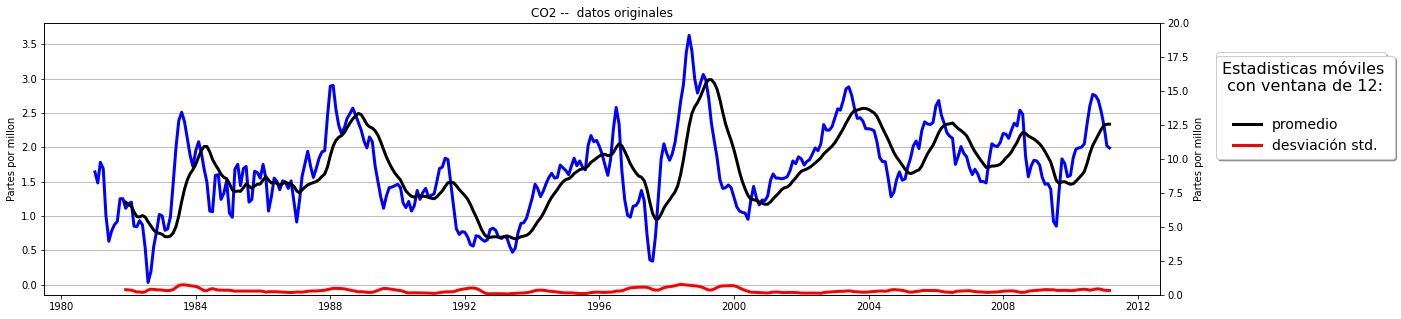


-- Test de Dickey-Fuller:
Test Statistic                  -3.115189
p-value                          0.025449
#Lags Used                      16.000000
Number of Observations Used    346.000000
Critical Value (1%)             -3.449392
Critical Value (5%)             -2.869930
Critical Value (10%)            -2.571240
dtype: float64

 ** B) Primera diferencia


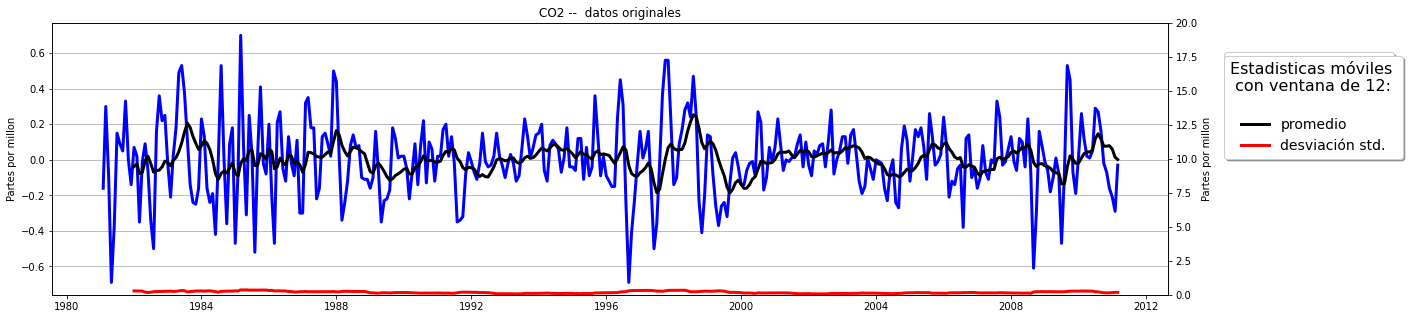


-- Test de Dickey-Fuller:
Test Statistic                -7.370083e+00
p-value                        9.019878e-11
#Lags Used                     1.500000e+01
Number of Observations Used    3.460000e+02
Critical Value (1%)           -3.449392e+00
Critical Value (5%)           -2.869930e+00
Critical Value (10%)          -2.571240e+00
dtype: float64

 ** B) Determinación de P y Q:


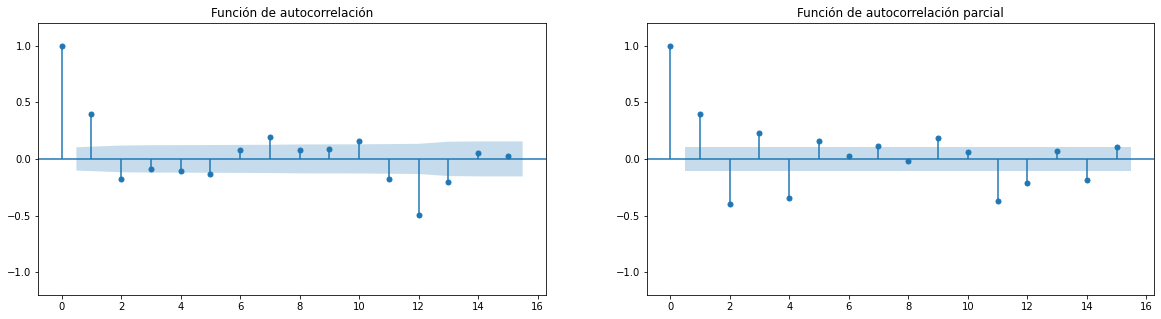

In [22]:
# Separamos los datos
data_CO2["data train"],data_CO2["data test"]=sep_data(data_CO2["all data"],"CO2")

# Hacemos el differencing de los datos observamos y estimamos el valor del parámetro d
print("\n --- Datos observados:")
print("\n ** A) Primera diferencia")
data_CO2["diff 1"]=data_CO2["data train"]-data_CO2["data train"].shift(periods=1)
test_stacionary(data_CO2["diff 1"],12,"CO2")

# Determinación parámetros p y q
print("\n ** B) Determinación de p y q:")
val_p_q(data_CO2["diff 1"])

# Hacemos el differencing de las observaciones estacionales y estimamos D
print("\n --- Datos estacionales:")

print("\n ** A) Datos sin differencing")
data_CO2["seasonal"]=data_CO2["data train"]-data_CO2["data train"].shift(periods=12)
test_stacionary(data_CO2["seasonal"],12,"CO2")

print("\n ** B) Primera diferencia")
data_CO2["seasonal diff 1"]=data_CO2["seasonal"]-data_CO2["seasonal"].shift(periods=1)
test_stacionary(data_CO2["seasonal diff 1"],12,"CO2")


# Determinación parámetros P y Q
print("\n ** B) Determinación de P y Q:")
val_p_q(data_CO2["seasonal diff 1"])



 -- modelo SARIMA(2, 1, 1)x(0, 1, 112)
                                     SARIMAX Results                                      
Dep. Variable:                         data train   No. Observations:                  375
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 251.589
Date:                            Wed, 02 Mar 2022   AIC                           -493.178
Time:                                    23:04:49   BIC                           -473.720
Sample:                                01-01-1980   HQIC                          -485.443
                                     - 03-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0782      0.063      1.242      0.214      -0.045       0

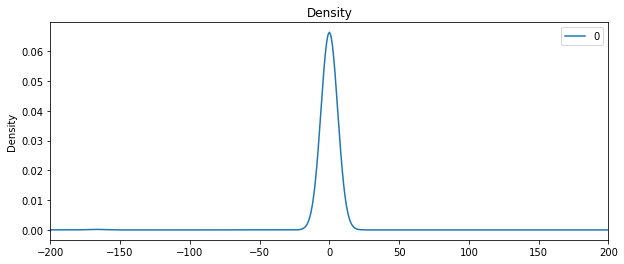

-- Resumen de los residuos:
                0
count  375.000000
mean     0.460187
std     19.555067
min   -168.725000
25%     -0.075763
50%      0.004523
75%      0.088507
max    338.550000

 --- Predicción de los datos:


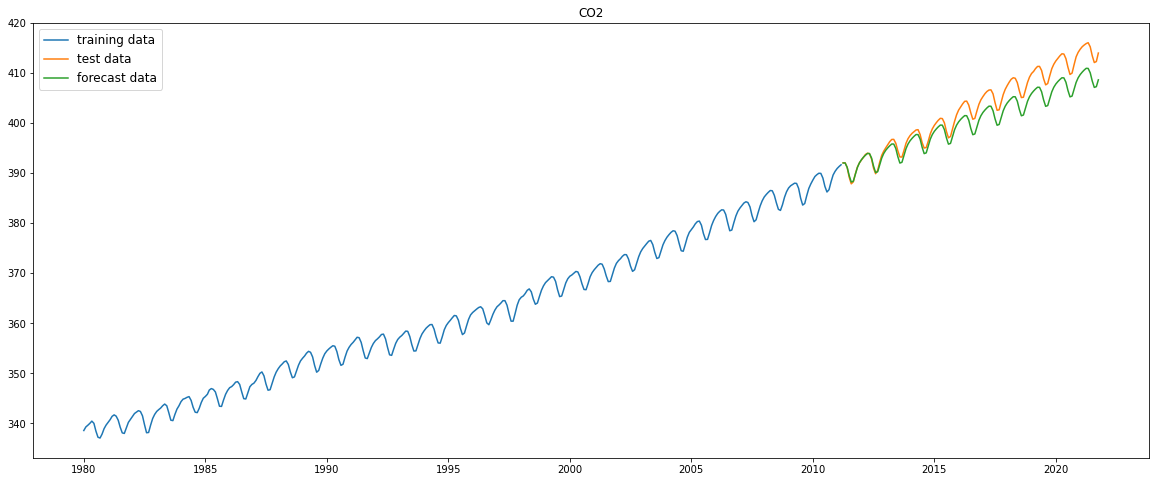

r2: 0.8399349784539051


In [23]:
# Ajuste del modelo
model_CO2=forecasting(data_CO2["data train"],2,1,1,0,1,1,12)

# Predicción de los datos
print("\n --- Predicción de los datos:")
predicion_datos(data_CO2,model_CO2,"CO2")

In [24]:
# sarima_model=auto_arima(data_CO2["data train"].dropna(axis=0),start_p=0,d=1,start_q=0,max_p=5,max_d=5,max_q=5,
#                        start_P=0,D=1,start_Q=0,max_P=3,max_Q=3,m=12,seasonal=True,error_action="warn",trace=True,
#                        supress_warning=True,stepwise=True,random_state=20,n_filts=50)